# Applied Data Science Capstone Project  - The Battle of Neighborhoods

## Table of contents
* [Introduction/Business Problem](#introduction)
* [Data acquisition](#data)
* [Methodology](#methodology)
* [Analysis](#analysis)
* [Results and Discussion](#results)
* [Conclusions](#conclusion)

## Introduction/Business Problem <a name="introduction"></a>

Bogotá is the metropolitan center of Colombia, which is located at 2,600 meters above sea level. This city offers varied artistic expressions such as museum exhibits, dance, theater, music, and splendid cuisine ([1](#ref1)). There are also hundreds of places to go to eat and frequent food festivals ([2](#ref2)), and consequently, the catering industry could be a very competitive field in this city.

In this project, the data available on restaurants and territorial distribution of Bogotá will be used to analyze and cluster different locations in which a restaurant could be potentially be established. It is also expected that the information analyzed can be useful to obtain a preliminary insight into the most appropriate types of restaurants and the users that are most likely to visit them. The results obtained in this study could be of interest to businessmen or investors that want to open a restaurant in Bogotá, Colombia.

## Data acquisition <a name="data"></a>

The necessary data to perform the analysis of the best locations for a restaurant in Bogotá, Colombia will be obtained from the following sources.
- Lists of the boroughs and neighborhoods and their geospatial position will be obtained from https://bogota-laburbano.opendatasoft.com/explore.
- Data about the territorial distribution of Bogotá will also be acquired from https://bogota-laburbano.opendatasoft.com/explore. This web page contains information about tourist, urban and company areas in Bogotá.
- The types and location of each restaurant in all the neighborhoods will be obtained from Foursquare API (www.foursquare.com).


## Methodology <a name="methodology"></a>

The methodology used in this project to determine the best locations for a restaurant in Bogotá, Colombia, is divided into four main parts:

- All the data needed about the neighborhoods in Bogotá, Colombia was first searched and collected. Taking as base the data available the next steps were carried out.

- The data about the boroughs and neighborhoods were cleaned and then analyzed in order to identify the boroughs that could have the most potential customers for the restaurant. Information about tourist places, offices and companies were used to examine the boroughs.

- Data about the most popular venues in each neighborhood were retrieved from the Foursquare API. Since this project is only focused on restaurants, the venues belonging to other categories were discarded. 

- The neighborhoods of the selected boroughs were clustered using the K-means model. The most common restaurant categories were used as based to perform the neighborhood segmentation.   

## Analysis <a name="analysis"></a>

The required libraries are first loaded

In [1]:
import numpy as np # library to handle data in a vectorized manner
import pandas as pd # library for data analsysis
import json # library to handle JSON files
#!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline 
import matplotlib as mpl
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans # import k-means from clustering stage

#!conda install -c conda-forge folium=0.5.0 --yes 
import folium # map rendering library

print('Libraries imported.')



Libraries imported.


### Neighbors and boroughs

The data of the neighborhoods and the boroughs with the geospatial position were imported. These data were organized in a dataframe.

In [2]:
!wget -O Bogota_Neighborhoods_data.json https://bogota-laburbano.opendatasoft.com/explore/dataset/barrios_prueba/download/?format=geojson&timezone=America/Bogota&lang=es
BN_df = pd.read_json('Bogota_Neighborhoods_data.json')
print(BN_df.shape)
BN_df.head()

--2021-01-20 21:39:25--  https://bogota-laburbano.opendatasoft.com/explore/dataset/barrios_prueba/download/?format=geojson
Resolving bogota-laburbano.opendatasoft.com (bogota-laburbano.opendatasoft.com)... 34.196.27.91, 52.1.105.32
Connecting to bogota-laburbano.opendatasoft.com (bogota-laburbano.opendatasoft.com)|34.196.27.91|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/json]
Saving to: 'Bogota_Neighborhoods_data.json'

     0K .......... .......... .......... .......... ..........  571K
    50K .......... .......... .......... .......... ..........  586K
   100K .......... .......... .......... .......... .......... 4,99M
   150K .......... .......... .......... .......... ..........  675K
   200K .......... .......... .......... .......... .......... 9,38M
   250K .......... .......... .......... .......... .......... 5,92M
   300K .......... .......... .......... .......... ..........  664K
   350K .......... .......... ........

(3871, 2)


type                                           features
0  FeatureCollection  {'type': 'Feature', 'geometry': {'type': 'Poly...
1  FeatureCollection  {'type': 'Feature', 'geometry': {'type': 'Poly...
2  FeatureCollection  {'type': 'Feature', 'geometry': {'type': 'Poly...
3  FeatureCollection  {'type': 'Feature', 'geometry': {'type': 'Poly...
4  FeatureCollection  {'type': 'Feature', 'geometry': {'type': 'Poly...

In [3]:
BN_df.loc[0, 'features']

{'type': 'Feature',
 'geometry': {'type': 'Polygon',
  'coordinates': [[[-74.12371661899999, 4.663646110000002],
    [-74.123719365, 4.663643638999985],
    [-74.12425022100001, 4.6631731859999945],
    [-74.12460715200001, 4.662829138000006],
    [-74.12578401500002, 4.661778562999984],
    [-74.12614453100002, 4.661512689999995],
    [-74.12854861800002, 4.664022563999992],
    [-74.12804310299998, 4.664472116000013],
    [-74.12684420699998, 4.665558498999985],
    [-74.12680204600002, 4.665596773999993],
    [-74.12601061700002, 4.666324700000018],
    [-74.12598091900003, 4.666192143999978],
    [-74.12560916500001, 4.665789309999979],
    [-74.12401446799998, 4.664056992999974],
    [-74.12368487499998, 4.663683961999993],
    [-74.12368128600002, 4.663679511999987],
    [-74.12371661899999, 4.663646110000002]]]},
 'properties': {'shape_area': 1.1687137258163001e-05,
  'objectid': 622,
  'barriocomu': 'S.C. Modelia Occidental',
  'shape_len': 0.013727078297699001,
  'geo_point_2d

All the information obtained in dictionary format was organized in a data frame. The rows without information about geospatial position were dropped. Three neighborhoods were also dropped because they were not assigned to any borough. In addition, some neighborhoods do not have any borough names specified. After examining all these rows, all of them corresponded to the same borough ID. Therefore, all of them were filled with the missing Borough name (Suba). The ID of two boroughs (Candelaria and Santa Fe) was corrected since both had the same value in this column.

In [4]:
BogNeighborhoods_df = pd.DataFrame(columns = ['ID_N', 'ID_B', 'Neighborhood','Borough', 'Latitude', 'Longitude'])

count = 0

for i in BN_df.index:    
    
    if BN_df.loc[i, 'features'].get('properties').get('geo_point_2d') == None:
        count +=1
        continue        # don't process it
    
    
    BogNeighborhoods_df = BogNeighborhoods_df.append({'ID_N': BN_df.loc[i, 'features'].get('properties').get('objectid'),
                                                      'ID_B': BN_df.loc[i, 'features'].get('properties').get('cod_loc'),
                                                      'Neighborhood': BN_df.loc[i, 'features'].get('properties').get('barriocomu'),
                                                      'Borough' : BN_df.loc[i, 'features'].get('properties').get('localidad'),
                                                      'Latitude' : BN_df.loc[i, 'features'].get('properties').get('geo_point_2d')[0],
                                                      'Longitude' : BN_df.loc[i, 'features'].get('properties').get('geo_point_2d')[1]
                                                      }, ignore_index=True)


print('Number of rows dropped for not belonging to any borough: {} '.format(len(BogNeighborhoods_df[BogNeighborhoods_df['ID_B'] == 0]))) 
BogNeighborhoods_df.drop(BogNeighborhoods_df[BogNeighborhoods_df['ID_B'] == 0].index, inplace = True) 
    
BogNeighborhoods_df.set_index('ID_N', inplace=True)
BogNeighborhoods_df.fillna(value='Suba', inplace=True) 
BogNeighborhoods_df.loc[BogNeighborhoods_df['Borough'] == 'Candelaria', 'ID_B'] = 17

print('Number of rows dropped because the geospatial position was missing: {} '.format(count)) 
print('The dataframe of the neighborhoods in Bogotá has {} rows and {} columns.'.format(BogNeighborhoods_df.shape[0], BogNeighborhoods_df.shape[1]))
   
    
BogNeighborhoods_df.head()


Number of rows dropped for not belonging to any borough: 3 
Number of rows dropped because the geospatial position was missing: 3 
The dataframe of the neighborhoods in Bogotá has 3865 rows and 5 columns.


ID_B                 Neighborhood   Borough  Latitude  Longitude
ID_N                                                                  
622      9      S.C. Modelia Occidental  Fontibón  4.663872 -74.126101
623      9                     Mallorca  Fontibón  4.667070 -74.129611
631     11  Cantalejo Sector Alejandría      Suba  4.745914 -74.057101
642      1                  Montearroyo   Usaquén  4.716169 -74.024873
654      1     Escuela de Caballería II   Usaquén  4.680785 -74.037319

In [5]:
address = 'Bogota, Colombia'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Bogotá are {}, {}.'.format(latitude, longitude))

# create map of Bogotá using latitude and longitude values
map_bogota = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, borough, neighborhood in zip(BogNeighborhoods_df['Latitude'], BogNeighborhoods_df['Longitude'], BogNeighborhoods_df['Borough'], BogNeighborhoods_df['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=2,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_bogota)  
    
map_bogota

The geograpical coordinate of Bogotá are 4.6533326, -74.083652.


Since the amount of neighborhoods obtained is very high (3865). The boroughs are going to be explored first in order to only consider the most suitable.
Bogotá is composed of 20 boroughs. The 20th borough (Sumapaz) is mostly rural and is less populated ([3](#ref3)). Therefore, this borough was not had into account in the database initially. 

In [6]:
b = len(BogNeighborhoods_df['Borough'].unique().tolist())
n = BogNeighborhoods_df['Borough'].unique()
print('The {} boroughs had into account are:'.format(b)) 
for i in n:
    print (i)

The 19 boroughs had into account are:
Fontibón
Suba
Usaquén
Rafael Uribe
Usme
San Cristóbal
Santa Fe
Barrios Unidos
Teusaquillo
Puente Aranda
Engativá
Kennedy
Bosa
Ciudad Bolívar
Los Mártires
Candelaria
Tunjuelito
Chapinero
Antonio Nariño


In [7]:
BogBoroughs_df = BogNeighborhoods_df.groupby('Borough').mean()

BogBoroughs_df = BogBoroughs_df.reset_index()
BogBoroughs_df = BogBoroughs_df.set_index('ID_B')
BogBoroughs_df = BogBoroughs_df.sort_values('ID_B')
BogBoroughs_df

Borough  Latitude  Longitude
ID_B                                     
1            Usaquén  4.734712 -74.031662
2          Chapinero  4.649913 -74.050649
3           Santa Fe  4.595280 -74.069871
4      San Cristóbal  4.557628 -74.086110
5               Usme  4.501817 -74.110217
6         Tunjuelito  4.578853 -74.138583
7               Bosa  4.619518 -74.191555
8            Kennedy  4.628286 -74.155276
9           Fontibón  4.675987 -74.141078
10          Engativá  4.700351 -74.114939
11              Suba  4.738390 -74.079011
12    Barrios Unidos  4.671068 -74.072016
13       Teusaquillo  4.638342 -74.086160
14      Los Mártires  4.606766 -74.088545
15    Antonio Nariño  4.590737 -74.105088
16     Puente Aranda  4.612981 -74.113413
17        Candelaria  4.594495 -74.072441
18      Rafael Uribe  4.562269 -74.114165
19    Ciudad Bolívar  4.555813 -74.153630

In order to explore the distribution and dynamics of all the boroughs, data about tourist places, office areas, and the number of companies in Bogotá were employed.

### Tourist places 	
A data frame containing information of all the tourist places in Bogotá and  their geospatial location was employed.

In [8]:
!wget -O Bogota_tourist_data.json https://bogota-laburbano.opendatasoft.com/explore/dataset/atractivo-turistico/download/?format=geojson&timezone=America/Bogota&lang=es
BT_df = pd.read_json('Bogota_tourist_data.json')
print(BT_df.shape)
BT_df.head()

(306, 2)


--2021-01-20 21:41:21--  https://bogota-laburbano.opendatasoft.com/explore/dataset/atractivo-turistico/download/?format=geojson
Resolving bogota-laburbano.opendatasoft.com (bogota-laburbano.opendatasoft.com)... 34.196.27.91, 52.1.105.32
Connecting to bogota-laburbano.opendatasoft.com (bogota-laburbano.opendatasoft.com)|34.196.27.91|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/json]
Saving to: 'Bogota_tourist_data.json'

     0K .......... .......... .......... .......... ..........  633K
    50K .......... .......... .......... ........              3,86M=0,09s

2021-01-20 21:41:22 (1002 KB/s) - 'Bogota_tourist_data.json' saved [91101]

"timezone" no se reconoce como un comando interno o externo,
programa o archivo por lotes ejecutable.
"lang" no se reconoce como un comando interno o externo,
programa o archivo por lotes ejecutable.


type                                           features
0  FeatureCollection  {'type': 'Feature', 'geometry': {'type': 'Poin...
1  FeatureCollection  {'type': 'Feature', 'geometry': {'type': 'Poin...
2  FeatureCollection  {'type': 'Feature', 'geometry': {'type': 'Poin...
3  FeatureCollection  {'type': 'Feature', 'geometry': {'type': 'Poin...
4  FeatureCollection  {'type': 'Feature', 'geometry': {'type': 'Poin...

In [9]:
BogTourist_df = pd.DataFrame(columns = ['ID_T', 'Tourist_place','Borough', 'Latitude', 'Longitude'])

for i in BT_df.index:    
    
    BogTourist_df  = BogTourist_df .append({'ID_T': BT_df.loc[i, 'features'].get('properties').get('objectid'),
                                            'Tourist_place': BT_df.loc[i, 'features'].get('properties').get('atunombre'),
                                            'Borough' : BT_df.loc[i, 'features'].get('properties').get('atulocalid'),
                                            'Latitude' : BT_df.loc[i, 'features'].get('properties').get('geo_point_2d')[0],
                                            'Longitude' : BT_df.loc[i, 'features'].get('properties').get('geo_point_2d')[1]
                                            }, ignore_index=True)

BogTourist_df.set_index('ID_T', inplace=True)

print('The dataframe of the Tourist places in Bogotá has {} rows and {} columns.'.format(BogTourist_df.shape[0], BogTourist_df.shape[1]))
   
BogTourist_df.head()

The dataframe of the Tourist places in Bogotá has 306 rows and 4 columns.


Tourist_place         Borough  Latitude  \
ID_T                                                                     
23       Iglesia de Nuestra Señora de Egipto   La Candelaria  4.593428   
12        Capilla Santa María de Los Ángeles       Chapinero  4.661364   
14                     Iglesia de Cristo Rey       Chapinero  4.684220   
181   Centro Urbano de Recreación  Compensar        Engativá  4.663018   
180               Centro de Alto Rendimiento  Barrios Unidos  4.659961   

      Longitude  
ID_T             
23   -74.068831  
12   -74.050652  
14   -74.051063  
181  -74.103709  
180  -74.085643

The borough with more tourist places is Candelaria, followed by Santa Fe and Chapinero. Restaurants located in these places are interesting since could be very attractive for tourists. 

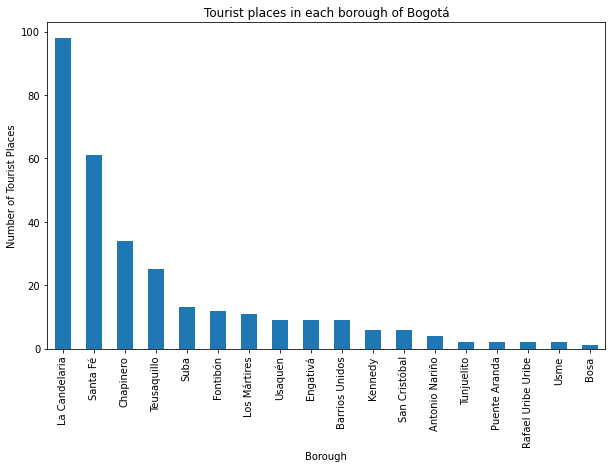

In [10]:
BogTourist_df.groupby(['Borough']).count().sort_values(by='Tourist_place', ascending=False)['Tourist_place'].plot(kind='bar', figsize=(10, 6))
plt.xlabel('Borough') 
plt.ylabel('Number of Tourist Places') 
plt.title('Tourist places in each borough of Bogotá') 
plt.show()

The following map shows the locations of the boroughs (blue) and the places with tourist attractions (red). Most of the tourist places are located in the east of the city, where the borough La Candelaria, Santa Fé and Chapinero are located.

In [11]:
# create map of Bogotá using latitude and longitude values
map_bogota = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, borough, tplace in zip(BogTourist_df['Latitude'], BogTourist_df['Longitude'], BogTourist_df['Borough'], BogTourist_df['Tourist_place']):
    label = '{}, {}'.format(tplace, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=3,
        popup=label,
        color='red',
        fill=True,
        fill_color='#cc4631',
        fill_opacity=0.7,
        parse_html=False).add_to(map_bogota)  

for lat, lng, borough in zip(BogBoroughs_df['Latitude'], BogBoroughs_df['Longitude'], BogBoroughs_df['Borough']):
    label = '{}'.format(borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_bogota)  


map_bogota

### Offices and companies 
Data with information about offices and companies in Bogotá were used to explore each borough. The two dataframes contained data of areas destined to offices (between 2001 and 2015) and companies subscribed to the chamber of Trade and Industry in 2015. This information could be useful to find administrative and corporate zones, where many people work and need a restaurant close for meals.

In [12]:
!wget -O Bogota_offices_data.json https://bogota-laburbano.opendatasoft.com/explore/dataset/area-destinada-a-oficinas-que-inicio-proceso-de-construccion-en-bogota/download/?format=geojson&timezone=America/Bogota&lang=es
BO_df = pd.read_json('Bogota_offices_data.json')
print(BO_df.shape)
BO_df.head()

--2021-01-20 21:41:34--  https://bogota-laburbano.opendatasoft.com/explore/dataset/area-destinada-a-oficinas-que-inicio-proceso-de-construccion-en-bogota/download/?format=geojson
Resolving bogota-laburbano.opendatasoft.com (bogota-laburbano.opendatasoft.com)... 34.196.27.91, 52.1.105.32
Connecting to bogota-laburbano.opendatasoft.com (bogota-laburbano.opendatasoft.com)|34.196.27.91|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/json]
Saving to: 'Bogota_offices_data.json'

     0K .......... .......... .......... .......... ..........  584K
    50K .......... .......... .......... .......... ..........  588K
   100K .......... .......... .......... .......... ..........  634K
   150K .......... .......... .......... .......... .......... 2,37M
   200K .......... .......... .......... .......... ..........  770K
   250K .......... .......... .......... .......... .......... 4,91M
   300K .......... .......... .......... .......... .....

(20, 2)


type                                           features
0  FeatureCollection  {'type': 'Feature', 'geometry': {'type': 'Mult...
1  FeatureCollection  {'type': 'Feature', 'geometry': {'type': 'Mult...
2  FeatureCollection  {'type': 'Feature', 'geometry': {'type': 'Mult...
3  FeatureCollection  {'type': 'Feature', 'geometry': {'type': 'Mult...
4  FeatureCollection  {'type': 'Feature', 'geometry': {'type': 'Mult...

In [13]:
BO_df.loc[0, 'features']

{'type': 'Feature',
 'geometry': {'type': 'MultiPolygon',
  'coordinates': [[[[-74.072829117, 4.6154173318],
     [-74.072962044, 4.6155840828],
     [-74.077538124, 4.6220505558],
     [-74.078828209, 4.6238914938],
     [-74.083198947, 4.6246982888],
     [-74.099120239, 4.6050199228],
     [-74.099821755, 4.6042878488],
     [-74.10036843, 4.6036657898],
     [-74.101486888, 4.6025756278],
     [-74.10211273, 4.6020052698],
     [-74.10409074, 4.6004516078],
     [-74.105207342, 4.5996252088],
     [-74.107073006, 4.5982439888],
     [-74.104456081, 4.5961989148],
     [-74.104028266, 4.5958407748],
     [-74.103706065, 4.5954549478],
     [-74.103669459, 4.5953042978],
     [-74.103614549, 4.5950875058000005],
     [-74.103204473, 4.5946612558],
     [-74.103116587, 4.5947200368],
     [-74.102944487, 4.5947714688],
     [-74.102702815, 4.5947898228],
     [-74.102497762, 4.5947934808],
     [-74.1020547, 4.5948007978],
     [-74.099084549, 4.5949193698],
     [-74.090716051, 4.592

The areas between the years 2001 and 2015 were summed to get an approximation of the total areas that are currently used for offices. 

In [14]:
BogOffice_df = pd.DataFrame(columns = ['Borough','2001', '2002', '2003', '2004', '2005', '2006',  
                                                 '2007', '2008', '2009', '2010', '2011', '2012',
                                                 '2013', '2014', '2015'])

for i in BO_df.index:    
    
    BogOffice_df  = BogOffice_df.append({'Borough' : BO_df.loc[i, 'features'].get('properties').get('localidad'),
                                         '2001' : BO_df.loc[i, 'features'].get('properties').get('2001_0'),
                                         '2002' : BO_df.loc[i, 'features'].get('properties').get('2002_0'),
                                         '2003' : BO_df.loc[i, 'features'].get('properties').get('2003_0'),
                                         '2004' : BO_df.loc[i, 'features'].get('properties').get('2004_0'),
                                         '2005' : BO_df.loc[i, 'features'].get('properties').get('2005_0'),
                                         '2006' : BO_df.loc[i, 'features'].get('properties').get('2006_0'),
                                         '2007' : BO_df.loc[i, 'features'].get('properties').get('2007_0'),
                                         '2008' : BO_df.loc[i, 'features'].get('properties').get('2008_0'),
                                         '2009' : BO_df.loc[i, 'features'].get('properties').get('2009_0'),
                                         '2010' : BO_df.loc[i, 'features'].get('properties').get('2010_0'),
                                         '2011' : BO_df.loc[i, 'features'].get('properties').get('2011_0'),
                                         '2012' : BO_df.loc[i, 'features'].get('properties').get('2012_0'),
                                         '2013' : BO_df.loc[i, 'features'].get('properties').get('2013_0'),
                                         '2014' : BO_df.loc[i, 'features'].get('properties').get('2014_0'),
                                         '2015' : BO_df.loc[i, 'features'].get('properties').get('2015_0')
                                          }, ignore_index=True)

BogOffice_df.set_index('Borough', inplace=True)
BogOffice_df["Total office Area"] = BogOffice_df.sum(axis=1)


BogOffice_df = BogOffice_df.drop(['SIN INFORMACION'])
#print('The dataframe of a places in Bogotá has {} rows and {} columns.'.format(BogTourist_df.shape[0], BogTourist_df.shape[1]))
   
BogOffice_df.head()

2001   2002    2003   2004     2005  2006    2007  \
Borough                                                                   
LOS MARTIRES         245.0   35.0  2321.0  126.0    150.0   0.0   216.0   
TUNJUELITO           187.0    0.0     0.0    0.0      0.0   0.0   300.0   
TEUSAQUILLO         1660.0  909.0   385.0    0.0  26009.0   0.0  6769.0   
RAFAEL URIBE URIBE    50.0    0.0     0.0    0.0      0.0   0.0     0.0   
CIUDAD BOLIVAR         0.0    0.0     0.0    0.0      0.0   0.0     0.0   

                       2008     2009     2010   2011    2012     2013   2014  \
Borough                                                                        
LOS MARTIRES          110.0    456.0   1672.0  585.0  2878.0    723.0   82.0   
TUNJUELITO            340.0      0.0    467.0  800.0   240.0     90.0    0.0   
TEUSAQUILLO         12236.0  41572.0  33089.0  500.0   344.0  70051.0  772.0   
RAFAEL URIBE URIBE      0.0      0.0    383.0    0.0     0.0    260.0    0.0   
CIUDAD BOLIVAR          0.0      0.0    108.0    0.0   100.0      0.0    0.0   

                      2015  Total office Area  
Borough                                        
LOS MARTIRES        5089.0            14688.0  
TUNJUELITO           130.0             2554.0  
TEUSAQUILLO         2774.0           197070.0  
RAFAEL URIBE URIBE     0.0              693.0  
CIUDAD BOLIVAR         0.0              208.0

The bar plot shows that in the boroughs Chapinero and Usaquén are higher amounts of areas used for offices. 

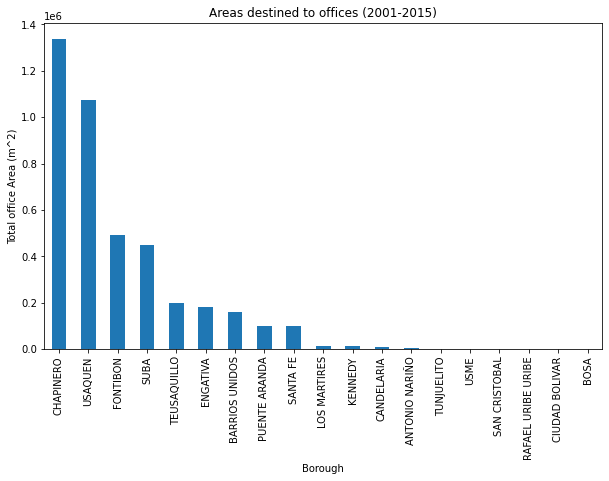

In [15]:
BogOffice_df.sort_values(by='Total office Area', ascending=False)['Total office Area'].plot(kind='bar', figsize=(10, 6))
plt.xlabel('Borough') 
plt.ylabel('Total office Area (m^2)') 
plt.title('Areas destined to offices (2001-2015)') 
plt.show()

In [16]:
!wget -O Bogota_companies_data.json https://bogota-laburbano.opendatasoft.com/explore/dataset/empresas-con-matricula-activa-en-la-camara-de-comercio-de-bogota/download/?format=geojson&timezone=America/Bogota&lang=es
BC_df = pd.read_json('Bogota_companies_data.json')
print(BC_df.shape)
BC_df.head()

--2021-01-20 21:41:37--  https://bogota-laburbano.opendatasoft.com/explore/dataset/empresas-con-matricula-activa-en-la-camara-de-comercio-de-bogota/download/?format=geojson
Resolving bogota-laburbano.opendatasoft.com (bogota-laburbano.opendatasoft.com)... 34.196.27.91, 52.1.105.32
Connecting to bogota-laburbano.opendatasoft.com (bogota-laburbano.opendatasoft.com)|34.196.27.91|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/json]
Saving to: 'Bogota_companies_data.json'

     0K .......... .......... .......... .......... ..........  542K
    50K .......... .......... .......... .......... ..........  614K
   100K .......... .......... .......... .......... .......... 3,48M
   150K .......... .......... .......... .......... .......... 3,22M
   200K .......... .......... .......... .......... ..........  749K
   250K .......... .......... .......... .......... .......... 7,99M
   300K .......... .......... .......... .......... .........

(21, 2)


type                                           features
0  FeatureCollection  {'type': 'Feature', 'geometry': {'type': 'Mult...
1  FeatureCollection  {'type': 'Feature', 'geometry': {'type': 'Mult...
2  FeatureCollection  {'type': 'Feature', 'geometry': {'type': 'Mult...
3  FeatureCollection  {'type': 'Feature', 'geometry': {'type': 'Mult...
4  FeatureCollection  {'type': 'Feature', 'geometry': {'type': 'Mult...

In [17]:
BC_df.loc[1, 'features']

{'type': 'Feature',
 'geometry': {'type': 'MultiPolygon',
  'coordinates': [[[[-74.185665868, 4.6470464198],
     [-74.185684959, 4.6470489608],
     [-74.185868295, 4.6471395268],
     [-74.185955151, 4.6473395658],
     [-74.185923004, 4.6476778238000005],
     [-74.185669064, 4.6481722948],
     [-74.185471878, 4.6486147848],
     [-74.185143431, 4.6490638798],
     [-74.184741658, 4.6496795758000005],
     [-74.184447988, 4.6502201488],
     [-74.184160719, 4.6508636808],
     [-74.183861646, 4.6514615628],
     [-74.183574014, 4.6520536608],
     [-74.18354241, 4.6524836688],
     [-74.183709538, 4.6527347788],
     [-74.183870175, 4.6528483968],
     [-74.184104228, 4.6528240708],
     [-74.184457284, 4.6526498638],
     [-74.184809523, 4.6523382588],
     [-74.185298608, 4.6519970878],
     [-74.185770847, 4.6517076228],
     [-74.186203904, 4.6515444398],
     [-74.186528944, 4.6514622558],
     [-74.186791738, 4.6514663108],
     [-74.187266791, 4.6516180618],
     [-74.187581

In [18]:
BogCompanies_df = pd.DataFrame(columns = ['Borough', 'Small', 'Medium and large'])

for i in BC_df.index:    
    
    BogCompanies_df  = BogCompanies_df .append({'Borough' : BC_df.loc[i, 'features'].get('properties').get('localidad'),
                                                'Small' : BC_df.loc[i, 'features'].get('properties').get('pequenas_2015'),
                                                'Medium and large' : BC_df.loc[i, 'features'].get('properties').get('grandes_y_medianas_2015')
                                               }, ignore_index=True)

BogCompanies_df.set_index('Borough', inplace=True)
BogCompanies_df = BogCompanies_df.drop(['SIN INFORMACION'])

BogCompanies_df.head()

Small  Medium and large
Borough                                 
SANTA FE        1184.0             339.0
BOSA             112.0              18.0
CIUDAD BOLIVAR   136.0              48.0
CHAPINERO       8162.0            3113.0
PUENTE ARANDA   1920.0             573.0

The figure shows the number of companies by size in each borough. The boroughs Chapinero and Usaquén have again the higher number of Large and small companies.  

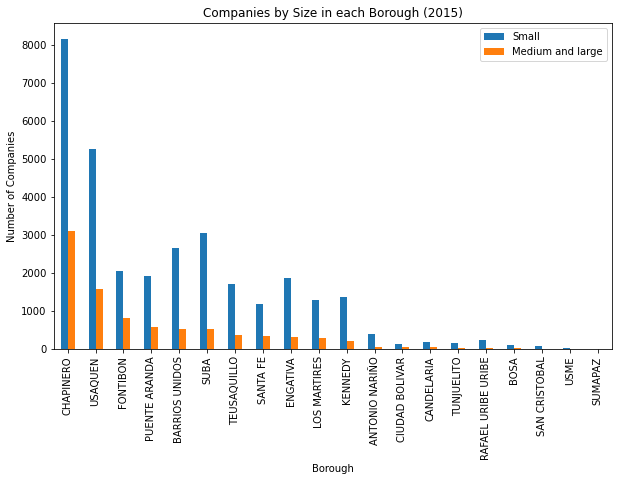

In [19]:
BogCompanies_df.sort_values(by='Medium and large', ascending=False).plot(kind='bar', figsize=(10, 6))
plt.xlabel('Borough') 
plt.ylabel('Number of Companies') 
plt.title('Companies by Size in each Borough (2015)') 
plt.show()

Based on the previuos analyzis only four bouroghs were having into account: Candelaria, Santa Fé, Chapinero and Usaquén.

In [20]:

BogNeighborhoods_df.drop(BogNeighborhoods_df[(BogNeighborhoods_df['Borough'] != 'Candelaria') &
                                             (BogNeighborhoods_df['Borough'] != 'Santa Fe') &
                                             (BogNeighborhoods_df['Borough'] != 'Chapinero') &
                                             (BogNeighborhoods_df['Borough'] != 'Usaquén')
                                            
                                            ].index, inplace = True)

print('The neighborhoods dataframe of the selected boroughs has {} rows and {} columns.'.format(BogNeighborhoods_df.shape[0], BogNeighborhoods_df.shape[1]))
  

BogNeighborhoods_df.head()

The neighborhoods dataframe of the selected boroughs has 455 rows and 5 columns.


ID_B              Neighborhood   Borough  Latitude  Longitude
ID_N                                                               
642      1               Montearroyo   Usaquén  4.716169 -74.024873
654      1  Escuela de Caballería II   Usaquén  4.680785 -74.037319
656      1               La Glorieta   Usaquén  4.696209 -74.027298
663      1   Cerros de Santa Bárbara   Usaquén  4.692080 -74.026955
736      3                 Cartagena  Santa Fe  4.579915 -74.076817

This map shows the location of the selected neighborhoods. It can be seen that the selected zone corresponds to the east of the city.

In [21]:
map_bogota = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, borough, neighborhood in zip(BogNeighborhoods_df['Latitude'], BogNeighborhoods_df['Longitude'], BogNeighborhoods_df['Borough'], BogNeighborhoods_df['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=2,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_bogota)  
    
map_bogota

 ### Importing venues from Foursquare API

The Foursquare API is used to retreive the most popular venues in each location. The Foursquare credentials and version are defined and due to the proximity of the neighborhoods, a limit of 100 venues in a radius of 250 meters is selected for each neighborhood.

In [22]:
import os 

CLIENT_ID = os.environ.get('Foursquare_API_CLIENT_ID') # Foursquare ID
CLIENT_SECRET = os.environ.get('Foursquare_API_CLIENT_SECRET') # Foursquare Secret
VERSION = '20180605' # Foursquare API version

LIMIT = 100 
radius = 150 

print('credentails uploaded')

credentails uploaded


The function to explore the venues in each neighborhood is defined

In [23]:
def getNearbyVenues(names, latitudes, longitudes):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

The function above is used to get the venues of the Neighborhoods selected

In [24]:
Bogota_venues = getNearbyVenues(names = BogNeighborhoods_df['Neighborhood'],
                                latitudes = BogNeighborhoods_df['Latitude'],
                                longitudes = BogNeighborhoods_df['Longitude']
                                ) 

Montearroyo
Escuela de Caballería II
La Glorieta
Cerros de Santa Bárbara
Cartagena
Gran Colombia
Portal de la Uribe
Nuevo Horizonte
Buenavista II_Sector
Terrazas de San Ángel
Los Sauces Norte
Urb. Carrera 32 186-07
La Catedral
San Norte
Delicias del Carmen
Lisboa_
Santa Bárbara Central III Sector
Santa Bibiana
San Patricio
Inzuca
Ciudadela Real
La_Carolina
Urb. San Antonio Norte
El Verbenal - Ayamonti
Tibabita II
La Franja de Buenavista
San Martín de Porres
El Dorado
Santa Bárbara
Bosques de Torca
Chico Norte - Urb. La Gran Vía
Belmira
Las_Acacias
Urb. Furatena
Chaparral
Bosque de los Pinos
Barrancas II Sector
Dorado Norte
Centro Administrativo
Cedritos
Santa Bárbara Alta
Ciudad Cooperativa La Libertad
Balmoral Norte
El Verbenal II Sector
Maranta I y II y III Sector
Cedro Norte
Urb. Torres de Madeira
Santa Cecilia Baja
S.C. Bellavista
Country Comodoro
El Cerro Parte Baja (Villa Nydia)
S.C. Bosque de Pinos
Desarrollo Metropolitan Club
Bosque de Pinos III
Country Club
S.C. San Norte
San


In [25]:
BogNeighborhoods_df['Neighborhood']

ID_N
642                  Montearroyo
654     Escuela de Caballería II
656                  La Glorieta
663      Cerros de Santa Bárbara
736                    Cartagena
                  ...           
1           Arboleda del Country
88                   Los Rosales
116                  El Consuelo
947                   Los Caobos
1345             Fabrica de Loza
Name: Neighborhood, Length: 455, dtype: object

In [26]:
print('The total number of venues obtained is {}.'.format(Bogota_venues.shape[0]))
Bogota_venues.head()

The total number of venues obtained is 2356.


Neighborhood  Neighborhood Latitude  Neighborhood Longitude  \
0  Escuela de Caballería II               4.680785              -74.037319   
1  Escuela de Caballería II               4.680785              -74.037319   
2  Escuela de Caballería II               4.680785              -74.037319   
3  Escuela de Caballería II               4.680785              -74.037319   
4               La Glorieta               4.696209              -74.027298   

                                  Venue  Venue Latitude  Venue Longitude  \
0                     OMA Capital Tower        4.679658       -74.038817   
1                           La Española        4.681002       -74.039371   
2  Sopas de Mama y Postres de la Abuela        4.680778       -74.038372   
3           Restaurante el Fogón Casero        4.680882       -74.039000   
4                      Catación Pública        4.695898       -74.028142   

              Venue Category  
0             Breakfast Spot  
1         Spanish Restaurant  
2  Latin American Restaurant  
3                 Restaurant  
4                Coffee Shop

Since this project focuses only on restaurants, all the other venues that do not contain the word restaurant in the venue category column are dropped. 

In [27]:
Bogota_venues = Bogota_venues[Bogota_venues['Venue Category'].str.contains('Restaurant')]
print('The total number of restaurant venues obtained is {}.'.format(Bogota_venues.shape[0]))

The total number of restaurant venues obtained is 654.


The figure shows the number of venues for each restaurant category. Most of the venues are only categorized as restaurants, therefore these do not belong to any specific category. The Italian and fast-food restaurants would be the type of restaurants more common in the chosen boroughs. 

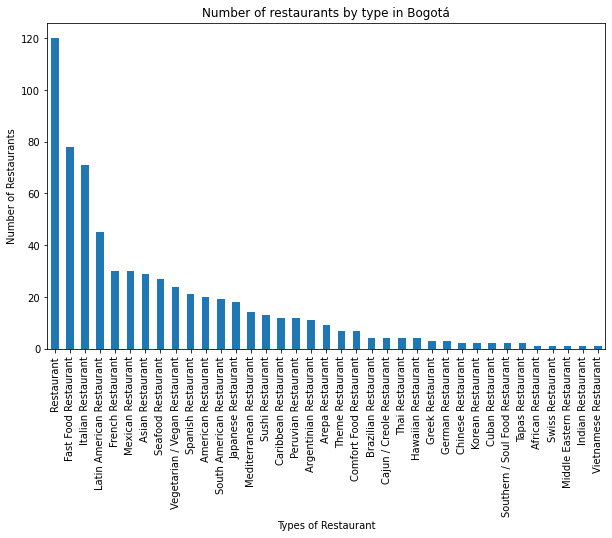

In [28]:
Bogota_venues.groupby('Venue Category').count().sort_values(by='Venue', ascending=False)['Venue'].plot(kind='bar', figsize=(10, 6))
plt.xlabel('Types of Restaurant') 
plt.ylabel('Number of Restaurants') 
plt.title('Number of restaurants by type in Bogotá') 
plt.show()

The following figure shows the number of restaurants in each borough. The boroughs Usaquén and Chapinero have a considerable difference in comparison with the two last ones (Santa Fé and La Candelaria).

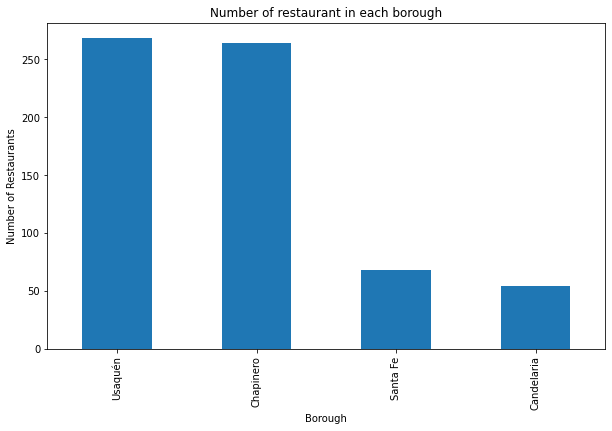

In [29]:
pd.merge(Bogota_venues, BogNeighborhoods_df, on="Neighborhood").groupby('Borough').count().sort_values(by='Venue', ascending=False)['Venue'].plot(kind='bar', figsize=(10, 6))
plt.xlabel('Borough') 
plt.ylabel('Number of Restaurants') 
plt.title('Number of restaurant in each borough') 
plt.show()

### Clustering

Before segmenting the Neighborhoods in clusters, the data should be arranged. The dummie function is used to create a binary column for each category, then to this dataframe is inserted the column with the neighborhoods. Then The rows are grouped by neighborhood and the mean frequency is taken for each category.

In [30]:
# one hot encoding
Bogota_onehot = pd.get_dummies(Bogota_venues[['Venue Category']], prefix="", prefix_sep="")
Bogota_onehot
# add neighborhood column back to dataframe
Bogota_neighbors = pd.DataFrame(Bogota_venues['Neighborhood'])
Bogota_onehotm = Bogota_neighbors.merge(Bogota_onehot, left_index=True, right_index=True)

Bogota_grouped = Bogota_onehotm.groupby('Neighborhood').mean().reset_index()
print(Bogota_grouped.shape)
Bogota_grouped

(178, 38)


Neighborhood  African Restaurant  \
0                              Acacias Usaquén                 0.0   
1                            Altos de la Salle                 0.0   
2                         Arboleda del Country                 0.0   
3                                    Babilonia                 0.0   
4                                    Barrancas                 0.0   
..                                         ...                 ...   
173                                 Veracruz__                 0.0   
174                         Verbenal II Sector                 0.0   
175                              Villa Magdala                 0.0   
176  Villa Nueva Urb. (Tafur Morales II Etapa)                 0.0   
177                                    Zamudio                 0.0   

     American Restaurant  Arepa Restaurant  Argentinian Restaurant  \
0               0.000000               0.0                     0.0   
1               0.333333               0.0                     0.0   
2               0.000000               0.0                     0.0   
3               0.000000               0.5                     0.0   
4               0.000000               0.0                     0.0   
..                   ...               ...                     ...   
173             0.000000               0.0                     0.0   
174             0.000000               0.0                     0.0   
175             0.000000               0.0                     0.0   
176             0.000000               0.0                     0.0   
177             0.000000               0.0                     0.0   

     Asian Restaurant  Brazilian Restaurant  Cajun / Creole Restaurant  \
0                 0.0                   0.0                        0.0   
1                 0.0                   0.0                        0.0   
2                 0.0                   0.0                        0.0   
3                 0.0                   0.0                        0.0   
4                 0.0                   0.0                        0.0   
..                ...                   ...                        ...   
173               0.0                   0.0                        0.0   
174               0.0                   0.0                        0.0   
175               0.0                   0.0                        0.0   
176               0.0                   0.0                        0.0   
177               0.0                   0.0                        0.0   

     Caribbean Restaurant  Chinese Restaurant  ...  South American Restaurant  \
0                     0.0                 0.0  ...                        0.0   
1                     0.0                 0.0  ...                        0.0   
2                     0.0                 0.0  ...                        0.0   
3                     0.0                 0.0  ...                        0.0   
4                     0.0                 0.0  ...                        0.0   
..                    ...                 ...  ...                        ...   
173                   0.0                 0.0  ...                        0.5   
174                   0.0                 0.0  ...                        0.0   
175                   0.0                 0.0  ...                        0.0   
176                   0.0                 0.0  ...                        0.0   
177                   0.0                 0.0  ...                        0.0   

     Southern / Soul Food Restaurant  Spanish Restaurant  Sushi Restaurant  \
0                                0.0                 0.0               0.0   
1                                0.0                 0.0               0.0   
2                                0.0                 0.0               0.0   
3                                0.0                 0.0               0.0   
4                                0.0                 0.0               0.0   
..                    

The next code is used to obtain the 5 most common categories in each neighborhood

In [31]:
num_top_venues = 5

for hood in Bogota_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = Bogota_grouped[Bogota_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Acacias Usaquén----
                       venue  freq
0         Mexican Restaurant   0.5
1       Fast Food Restaurant   0.5
2         African Restaurant   0.0
3  South American Restaurant   0.0
4   Mediterranean Restaurant   0.0


----Altos de la Salle----
                           venue  freq
0            Japanese Restaurant  0.33
1  Vegetarian / Vegan Restaurant  0.33
2            American Restaurant  0.33
3               Theme Restaurant  0.00
4                Thai Restaurant  0.00


----Arboleda del Country----
                       venue  freq
0       Fast Food Restaurant   1.0
1         African Restaurant   0.0
2  South American Restaurant   0.0
3   Mediterranean Restaurant   0.0
4         Mexican Restaurant   0.0


----Babilonia----
                             venue  freq
0                 Arepa Restaurant   0.5
1             Fast Food Restaurant   0.5
2               African Restaurant   0.0
3  Southern / Soul Food Restaurant   0.0
4               Mexican Restaurant   0

4   Mediterranean Restaurant   0.0


----Egipto 2----
                       venue  freq
0         Mexican Restaurant   1.0
1         African Restaurant   0.0
2          Korean Restaurant   0.0
3   Mediterranean Restaurant   0.0
4  Middle Eastern Restaurant   0.0


----El Contador----
                       venue  freq
0  Latin American Restaurant  0.25
1         Italian Restaurant  0.25
2           Sushi Restaurant  0.25
3                 Restaurant  0.25
4  South American Restaurant  0.00


----El Danubio----
                      venue  freq
0                Restaurant   1.0
1        African Restaurant   0.0
2         Korean Restaurant   0.0
3  Mediterranean Restaurant   0.0
4        Mexican Restaurant   0.0


----El Moral----
                       venue  freq
0       Fast Food Restaurant   1.0
1         African Restaurant   0.0
2  South American Restaurant   0.0
3   Mediterranean Restaurant   0.0
4         Mexican Restaurant   0.0


----El Otoño----
                       venue  f

4         Mexican Restaurant   0.0


----Los Consuelos----
                       venue  freq
0       Fast Food Restaurant   1.0
1         African Restaurant   0.0
2  South American Restaurant   0.0
3   Mediterranean Restaurant   0.0
4         Mexican Restaurant   0.0


----Los Olivos----
                       venue  freq
0         Italian Restaurant   1.0
1         African Restaurant   0.0
2  South American Restaurant   0.0
3   Mediterranean Restaurant   0.0
4         Mexican Restaurant   0.0


----Los Sauces Norte----
                       venue  freq
0         Spanish Restaurant   1.0
1         African Restaurant   0.0
2  South American Restaurant   0.0
3   Mediterranean Restaurant   0.0
4         Mexican Restaurant   0.0


----Lourdes 2----
                       venue  freq
0           Theme Restaurant   1.0
1         African Restaurant   0.0
2  South American Restaurant   0.0
3   Mediterranean Restaurant   0.0
4         Mexican Restaurant   0.0


----Lourdes III----
           

4               Asian Restaurant  0.10


----S.C. Sucre----
                           venue  freq
0             Italian Restaurant  0.22
1               Arepa Restaurant  0.11
2         Argentinian Restaurant  0.11
3  Vegetarian / Vegan Restaurant  0.11
4             Mexican Restaurant  0.11


----Sagrado Corazón----
                       venue  freq
0                 Restaurant  0.50
1       Fast Food Restaurant  0.12
2     Argentinian Restaurant  0.12
3         Italian Restaurant  0.12
4  Latin American Restaurant  0.12


----Sagrado_Corazón----
                           venue  freq
0  Vegetarian / Vegan Restaurant  0.17
1             Italian Restaurant  0.17
2      Latin American Restaurant  0.08
3      South American Restaurant  0.08
4             Mexican Restaurant  0.08


----Samper----
                           venue  freq
0                     Restaurant  0.33
1             Mexican Restaurant  0.22
2  Vegetarian / Vegan Restaurant  0.11
3             Italian Restaurant  0.1

4         Mexican Restaurant   0.0


----Tibabita - El Caramely----
                       venue  freq
0        American Restaurant   1.0
1  South American Restaurant   0.0
2  Latin American Restaurant   0.0
3   Mediterranean Restaurant   0.0
4         Mexican Restaurant   0.0


----Tibabita El Reposo----
                             venue  freq
0        Cajun / Creole Restaurant   0.5
1             Fast Food Restaurant   0.5
2               African Restaurant   0.0
3  Southern / Soul Food Restaurant   0.0
4               Mexican Restaurant   0.0


----Tibabita I Sector----
                             venue  freq
0        Cajun / Creole Restaurant   0.5
1             Fast Food Restaurant   0.5
2               African Restaurant   0.0
3  Southern / Soul Food Restaurant   0.0
4               Mexican Restaurant   0.0


----Torcoroma_----
                       venue  freq
0                 Restaurant   0.5
1       Fast Food Restaurant   0.5
2         African Restaurant   0.0
3  South Ame

This function is used to sort the venues in descending order

In [32]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

A dataframe is created to display the 10 most common venues categories in each neighborhood

In [33]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = Bogota_grouped['Neighborhood']

for ind in np.arange(Bogota_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(Bogota_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

Neighborhood 1st Most Common Venue  2nd Most Common Venue  \
0       Acacias Usaquén    Mexican Restaurant   Fast Food Restaurant   
1     Altos de la Salle   Japanese Restaurant    American Restaurant   
2  Arboleda del Country  Fast Food Restaurant  Vietnamese Restaurant   
3             Babilonia      Arepa Restaurant   Fast Food Restaurant   
4             Barrancas  Fast Food Restaurant  Vietnamese Restaurant   

           3rd Most Common Venue    4th Most Common Venue  \
0          Vietnamese Restaurant  Comfort Food Restaurant   
1  Vegetarian / Vegan Restaurant         Arepa Restaurant   
2             Italian Restaurant      Hawaiian Restaurant   
3          Vietnamese Restaurant  Comfort Food Restaurant   
4             Italian Restaurant      Hawaiian Restaurant   

    5th Most Common Venue 6th Most Common Venue 7th Most Common Venue  \
0     Hawaiian Restaurant      Greek Restaurant     German Restaurant   
1  Argentinian Restaurant      Asian Restaurant  Brazilian Restaurant   
2        Greek Restaurant     German Restaurant     French Restaurant   
3     Hawaiian Restaurant      Greek Restaurant     German Restaurant   
4        Greek Restaurant     German Restaurant     French Restaurant   

       8th Most Common Venue    9th Most Common Venue 10th Most Common Venue  
0          French Restaurant         Cuban Restaurant     Chinese Restaurant  
1  Cajun / Creole Restaurant     Caribbean Restaurant     Italian Restaurant  
2           Cuban Restaurant  Comfort Food Restaurant     Chinese Restaurant  
3          French Restaurant         Cuban Restaurant     Chinese Restaurant  
4           Cuban Restaurant  Comfort Food Restaurant     Chinese Restaurant

The dataframe obtained above is used to cluster the neighborhoods in 5 groups

In [34]:
# set number of clusters
kclusters = 5
Bogota_grouped_clustering = Bogota_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(Bogota_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:20] 

array([0, 4, 0, 0, 0, 0, 1, 0, 4, 3, 3, 1, 4, 1, 1, 2, 2, 0, 1, 1])

The dataframe with the cluster labels and most common venue category are grouped with the dataframe that contains the geospatial position of each neighborhood. Both dataframe have in common the neighborhood column, which is used to pair the rows. Some neighborhoods had to be dropped since for them,  data were not obtained from the Foursquare API.

In [35]:
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)
Bogota_merged = pd.merge(BogNeighborhoods_df, neighborhoods_venues_sorted)
Bogota_merged.head()

ID_B                      Neighborhood     Borough  Latitude  Longitude  \
0     1          Escuela de Caballería II     Usaquén  4.680785 -74.037319   
1     1                       La Glorieta     Usaquén  4.696209 -74.027298   
2     1                  Los Sauces Norte     Usaquén  4.735974 -74.027742   
3    17                       La Catedral  Candelaria  4.599540 -74.073553   
4     1  Santa Bárbara Central III Sector     Usaquén  4.694677 -74.035788   

   Cluster Labels      1st Most Common Venue          2nd Most Common Venue  \
0               4                 Restaurant      Latin American Restaurant   
1               4         Italian Restaurant  Vegetarian / Vegan Restaurant   
2               2         Spanish Restaurant          Vietnamese Restaurant   
3               4  Latin American Restaurant                     Restaurant   
4               1                 Restaurant          Vietnamese Restaurant   

     3rd Most Common Venue      4th Most Common Venue 5th Most Common Venue  \
0       Spanish Restaurant      Vietnamese Restaurant      Greek Restaurant   
1      Hawaiian Restaurant  Latin American Restaurant  Brazilian Restaurant   
2       Chinese Restaurant        Hawaiian Restaurant      Greek Restaurant   
3       Seafood Restaurant    Comfort Food Restaurant    Italian Restaurant   
4  Comfort Food Restaurant        Hawaiian Restaurant      Greek Restaurant   

  6th Most Common Venue   7th Most Common Venue  \
0     German Restaurant       French Restaurant   
1      Cuban Restaurant        Greek Restaurant   
2     German Restaurant       French Restaurant   
3      Arepa Restaurant  Argentinian Restaurant   
4     German Restaurant       French Restaurant   

           8th Most Common Venue 9th Most Common Venue  \
0           Fast Food Restaurant      Cuban Restaurant   
1              German Restaurant     French Restaurant   
2           Fast Food Restaurant      Cuban Restaurant   
3  Vegetarian / Vegan Restaurant     German Restaurant   
4           Fast Food Restaurant      Cuban Restaurant   

    10th Most Common Venue  
0  Comfort Food Restaurant  
1     Fast Food Restaurant  
2  Comfort Food Restaurant  
3        French Restaurant  
4       Chinese Restaurant

Now, we can see how the neighborhoods in each cluster are destributed in the map of Bogotá.

In [36]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, bor, cluster in zip(Bogota_merged['Latitude'], Bogota_merged['Longitude'], Bogota_merged['Neighborhood'], Bogota_merged['Borough'], Bogota_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ', ' + str(bor) + ', ' + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

## Results and Discussion <a name="results"></a>

The data obtained for the boroughs were used to select the best possible boroughs for a restaurant. The number of companies, area of offices and number of tourist places in each borough were assesed. This allowed to group the selected boroughs in three types: 

- Boroughs mainly tourists as La Candelaria and Santa Fé, which have a higher number of tourist places and a low number of offices and companies. 

- an industrial/occupational borough (Usaquén) which higher number of offices and companies and a lower number of tourist places. 

- and a borough Mixed (Chapinero), where there is a high number of office areas and companies and a considerable amount of tourist places.

This classification could help to identify the kind of costumers that could be expected in each borough. As it was shown above, turists boroughs as La Candelaria and Santa Fé have a very lower amount of restaurants in comparisson with the other two bouroghs explored. On the other hand, the Italian and fast-food restaurant are the most common type of restaurants in the zomes explored. Interestingly, Latin American food restaurants occupy third place with a considerable difference from the first two restaurant types.  

The neighborhoods were clustered based on the most common restaurant category in each one of them. The classification and how each cluster is interpreted is shown below:

### Cluster 0 
(Red dots)
In this cluster, the fast-food restaurants are the most common restaurant types. These neighborhoods are mostly located in Usaquen. Despite this borough has a low number of tourist attractions, has a considerable number of companies and office areas. Therefore, the high number of fast-food restaurants could be due to workers or locals that do not search high price restaurants. 

In [37]:
Bogota_merged.loc[Bogota_merged['Cluster Labels'] == 0, Bogota_merged.columns[[1] + list(range(5, Bogota_merged.shape[1]))]].head()

Neighborhood  Cluster Labels 1st Most Common Venue  \
7                   Inzuca               0  Fast Food Restaurant   
8   El Verbenal - Ayamonti               0  Fast Food Restaurant   
11     Barrancas II Sector               0  Fast Food Restaurant   
15   El Verbenal II Sector               0  Fast Food Restaurant   
22    Parcelación Tibabita               0    Mexican Restaurant   

    2nd Most Common Venue  3rd Most Common Venue    4th Most Common Venue  \
7   Vietnamese Restaurant     Italian Restaurant      Hawaiian Restaurant   
8   Vietnamese Restaurant     Italian Restaurant      Hawaiian Restaurant   
11  Vietnamese Restaurant     Italian Restaurant      Hawaiian Restaurant   
15  Vietnamese Restaurant     Italian Restaurant      Hawaiian Restaurant   
22   Fast Food Restaurant  Vietnamese Restaurant  Comfort Food Restaurant   

   5th Most Common Venue 6th Most Common Venue 7th Most Common Venue  \
7       Greek Restaurant     German Restaurant     French Restaurant   
8       Greek Restaurant     German Restaurant     French Restaurant   
11      Greek Restaurant     German Restaurant     French Restaurant   
15      Greek Restaurant     German Restaurant     French Restaurant   
22   Hawaiian Restaurant      Greek Restaurant     German Restaurant   

   8th Most Common Venue    9th Most Common Venue 10th Most Common Venue  
7       Cuban Restaurant  Comfort Food Restaurant     Chinese Restaurant  
8       Cuban Restaurant  Comfort Food Restaurant     Chinese Restaurant  
11      Cuban Restaurant  Comfort Food Restaurant     Chinese Restaurant  
15      Cuban Restaurant  Comfort Food Restaurant     Chinese Restaurant  
22     French Restaurant         Cuban Restaurant     Chinese Restaurant

### Cluster 1
(Purple dots) 
This cluster corresponds mainly to neighborhoods with restaurants without a defined category assigned and other international food restaurants. The neighborhoods of this cluster are located mostly north in the boroughs of Chapinero and Usaquén.

In [38]:
Bogota_merged.loc[Bogota_merged['Cluster Labels'] == 1, Bogota_merged.columns[[1] + list(range(5, Bogota_merged.shape[1]))]].head()

Neighborhood  Cluster Labels 1st Most Common Venue  \
4   Santa Bárbara Central III Sector               1            Restaurant   
5                      Santa Bibiana               1            Restaurant   
10                     Urb. Furatena               1            Restaurant   
12                      Dorado Norte               1  Fast Food Restaurant   
16                       Cedro Norte               1            Restaurant   

    2nd Most Common Venue    3rd Most Common Venue    4th Most Common Venue  \
4   Vietnamese Restaurant  Comfort Food Restaurant      Hawaiian Restaurant   
5    Fast Food Restaurant    Vietnamese Restaurant  Comfort Food Restaurant   
10  Vietnamese Restaurant  Comfort Food Restaurant      Hawaiian Restaurant   
12             Restaurant    Vietnamese Restaurant  Comfort Food Restaurant   
16  Vietnamese Restaurant  Comfort Food Restaurant      Hawaiian Restaurant   

   5th Most Common Venue 6th Most Common Venue 7th Most Common Venue  \
4       Greek Restaurant     German Restaurant     French Restaurant   
5    Hawaiian Restaurant      Greek Restaurant     German Restaurant   
10      Greek Restaurant     German Restaurant     French Restaurant   
12   Hawaiian Restaurant      Greek Restaurant     German Restaurant   
16      Greek Restaurant     German Restaurant     French Restaurant   

   8th Most Common Venue 9th Most Common Venue 10th Most Common Venue  
4   Fast Food Restaurant      Cuban Restaurant     Chinese Restaurant  
5      French Restaurant      Cuban Restaurant     Chinese Restaurant  
10  Fast Food Restaurant      Cuban Restaurant     Chinese Restaurant  
12     French Restaurant      Cuban Restaurant     Chinese Restaurant  
16  Fast Food Restaurant      Cuban Restaurant     Chinese Restaurant

### Cluster 2
(Blue) 
The Spanish restaurants are the most common in these areas. With the exception of one, All the neighborhoods belonging to this cluster are located in Usaquén.  

In [39]:
Bogota_merged.loc[Bogota_merged['Cluster Labels'] == 2, Bogota_merged.columns[[1] + list(range(5, Bogota_merged.shape[1]))]].head()

Neighborhood  Cluster Labels 1st Most Common Venue  \
2        Los Sauces Norte               2    Spanish Restaurant   
40      Hipólito Restrepo               2    Spanish Restaurant   
45             California               2    Spanish Restaurant   
69  San José de Barrancas               2    Spanish Restaurant   
76      Cabañas del Norte               2    Spanish Restaurant   

    2nd Most Common Venue 3rd Most Common Venue 4th Most Common Venue  \
2   Vietnamese Restaurant    Chinese Restaurant   Hawaiian Restaurant   
40  Vietnamese Restaurant    Chinese Restaurant   Hawaiian Restaurant   
45  Vietnamese Restaurant    Chinese Restaurant   Hawaiian Restaurant   
69  Vietnamese Restaurant    Chinese Restaurant   Hawaiian Restaurant   
76  Vietnamese Restaurant    Chinese Restaurant   Hawaiian Restaurant   

   5th Most Common Venue 6th Most Common Venue 7th Most Common Venue  \
2       Greek Restaurant     German Restaurant     French Restaurant   
40      Greek Restaurant     German Restaurant     French Restaurant   
45      Greek Restaurant     German Restaurant     French Restaurant   
69      Greek Restaurant     German Restaurant     French Restaurant   
76      Greek Restaurant     German Restaurant     French Restaurant   

   8th Most Common Venue 9th Most Common Venue   10th Most Common Venue  
2   Fast Food Restaurant      Cuban Restaurant  Comfort Food Restaurant  
40  Fast Food Restaurant      Cuban Restaurant  Comfort Food Restaurant  
45  Fast Food Restaurant      Cuban Restaurant  Comfort Food Restaurant  
69  Fast Food Restaurant      Cuban Restaurant  Comfort Food Restaurant  
76  Fast Food Restaurant      Cuban Restaurant  Comfort Food Restaurant

### Cluster 3
(Cyan dots)
The Italian and other international restaurants are the most common in the neighborhoods belonging to this cluster. The neighborhoods that belong to this cluster are located in the boroughs Chapinero and Santa Fé. 

In [44]:
Bogota_merged.loc[Bogota_merged['Cluster Labels'] == 3, Bogota_merged.columns[[1] + list(range(5, Bogota_merged.shape[1]))]].head()

Neighborhood  Cluster Labels 1st Most Common Venue  \
53                    Manuela Beltrán               3    Italian Restaurant   
85                  Carolina Oriental               3    Italian Restaurant   
87                         Los Olivos               3    Italian Restaurant   
117                        Los Cerros               3    Italian Restaurant   
123  Bosque Calderón Tejada II Sector               3    Italian Restaurant   

     2nd Most Common Venue 3rd Most Common Venue 4th Most Common Venue  \
53   Vietnamese Restaurant   Hawaiian Restaurant      Greek Restaurant   
85   Vietnamese Restaurant   Hawaiian Restaurant      Greek Restaurant   
87   Vietnamese Restaurant   Hawaiian Restaurant      Greek Restaurant   
117  Vietnamese Restaurant   Hawaiian Restaurant      Greek Restaurant   
123  Vietnamese Restaurant   Hawaiian Restaurant      Greek Restaurant   

    5th Most Common Venue 6th Most Common Venue 7th Most Common Venue  \
53      German Restaurant     French Restaurant  Fast Food Restaurant   
85      German Restaurant     French Restaurant  Fast Food Restaurant   
87      German Restaurant     French Restaurant  Fast Food Restaurant   
117     German Restaurant     French Restaurant  Fast Food Restaurant   
123     German Restaurant     French Restaurant  Fast Food Restaurant   

    8th Most Common Venue    9th Most Common Venue 10th Most Common Venue  
53       Cuban Restaurant  Comfort Food Restaurant     Chinese Restaurant  
85       Cuban Restaurant  Comfort Food Restaurant     Chinese Restaurant  
87       Cuban Restaurant  Comfort Food Restaurant     Chinese Restaurant  
117      Cuban Restaurant  Comfort Food Restaurant     Chinese Restaurant  
123      Cuban Restaurant  Comfort Food Restaurant     Chinese Restaurant

### Cluster 4
(Orange dots)
In this cluster, the most frequent are the Latin American/southamerican restaurants, which also include Argentinian, Brazilian, Peruvian, Mexican and Cuban restaurants. These clusters are more common in all the boroughs explored but mainly in the south where there are more tourist attractions.

In [41]:
Bogota_merged.loc[Bogota_merged['Cluster Labels'] == 4, Bogota_merged.columns[[1] + list(range(5, Bogota_merged.shape[1]))]].head()

Neighborhood  Cluster Labels      1st Most Common Venue  \
0        Escuela de Caballería II               4                 Restaurant   
1                     La Glorieta               4         Italian Restaurant   
3                     La Catedral               4  Latin American Restaurant   
6                    San Patricio               4         Italian Restaurant   
9  Chico Norte - Urb. La Gran Vía               4  Latin American Restaurant   

           2nd Most Common Venue      3rd Most Common Venue  \
0      Latin American Restaurant         Spanish Restaurant   
1  Vegetarian / Vegan Restaurant        Hawaiian Restaurant   
3                     Restaurant         Seafood Restaurant   
6             Seafood Restaurant                 Restaurant   
9             Spanish Restaurant  South American Restaurant   

       4th Most Common Venue 5th Most Common Venue   6th Most Common Venue  \
0      Vietnamese Restaurant      Greek Restaurant       German Restaurant   
1  Latin American Restaurant  Brazilian Restaurant        Cuban Restaurant   
3    Comfort Food Restaurant    Italian Restaurant        Arepa Restaurant   
6  Latin American Restaurant   Peruvian Restaurant        Greek Restaurant   
9         Seafood Restaurant     French Restaurant  Argentinian Restaurant   

    7th Most Common Venue          8th Most Common Venue  \
0       French Restaurant           Fast Food Restaurant   
1        Greek Restaurant              German Restaurant   
3  Argentinian Restaurant  Vegetarian / Vegan Restaurant   
6        Asian Restaurant           Brazilian Restaurant   
9    Fast Food Restaurant                     Restaurant   

       9th Most Common Venue   10th Most Common Venue  
0           Cuban Restaurant  Comfort Food Restaurant  
1          French Restaurant     Fast Food Restaurant  
3          German Restaurant        French Restaurant  
6  Cajun / Creole Restaurant     Caribbean Restaurant  
9         Chinese Restaurant        German Restaurant

## Conclusions <a name="conclusion"></a>

In this project the data available of the neighborhoods in Bogotá, Colombia was used to explore and cluster them in order to obtain insights into the distributions of restaurants in the city. Data of tourist places, companies, and office areas were used to explore the boroughs and select the most adequate ones. A deeper exploration is needed in order to obtain a better description that allows determining the boroughs that have the best characteristics or have a higher possible number of customers for a restaurant. In order to do this, more data would be needed, as for example information about urban zones, malls, trading points, etc.   

The neighborhoods were clustered in five groups based on the most common restaurant categories, in each one of them. This allowed finding areas where there are similar types of restaurants. Tourist neighborhoods like Santa Fé and La Candelaria were found to have a lower number of restaurants, and most of them Latin-American food is served. In Usaquén, where there are a considerable number of offices and companies, the fast-food restaurants were the most common. The last borough explored Chapinero has both tourist and business areas, and here different international food restaurants were found. It is expected that this analysis could help investors from the catering industry who are planning to start a business in one of Bogotá neighborhoods.

### References

(1<a name="ref1"></a>) Visit Colombia feel the rhythm (2021/01) Tourism in Bogota: a city for experiencing culture. https://colombia.travel/en/blog/tourism-bogota-city-experiencing-culture

(2<a name="ref2"></a>) Tripadvisor. (2021/01) Explora Bogotá. https://www.tripadvisor.co/Tourism-g294074-Bogota-Vacations.html


(3<a name="ref3"></a>)  Alcaldía de Bogotá D.C. (2021/01) https://bogota.gov.co/mi-ciudad/localidades/sumapaz
